## Caricamento dei dati

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from supabase import create_client
from dotenv import load_dotenv
import os

# Carica da Supabase
load_dotenv('../.env')
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase = create_client(url, key)

# Fetch tutti i match (ordinati per data)
response = supabase.table('matches').select('*').order('date').execute()
df = pd.DataFrame(response.data)

# Converti date
df['date'] = pd.to_datetime(df['date'])

print(f"Loaded {len(df)} matches from Supabase")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.head()

Loaded 2000 matches from Supabase
Date range: 2021-08-21 00:00:00 to 2024-02-17 00:00:00


,id,date,season,home_team,away_team,home_goals,away_goals,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_corners,away_corners,home_fouls,away_fouls,result
0,1,2021-08-21,2021-22,Inter,Genoa,4,0,17,11,8,5,8,2,18,7,H
1,2,2021-08-21,2021-22,Verona,Sassuolo,2,3,12,15,4,8,7,4,11,12,A
2,3,2021-08-21,2021-22,Empoli,Lazio,1,3,16,8,5,5,5,3,13,10,A
3,4,2021-08-21,2021-22,Torino,Atalanta,1,2,19,6,8,2,5,1,17,13,A
4,1581,2021-08-21,2021-22,Inter,Genoa,4,0,17,11,8,5,8,2,18,7,H


## Creazione ELO

In [2]:
def calculate_elo_rating(df, k_factor=20, initial_rating=1500):
    """
    Calcola Elo rating per ogni squadra dopo ogni match
    
    k_factor: quanto velocemente cambia il rating (20 = standard)
    initial_rating: rating iniziale per tutte le squadre
    """
    
    # Inizializza ratings
    elo_ratings = {}
    
    # Liste per salvare Elo pre-match
    home_elo_before = []
    away_elo_before = []
    
    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        result = row['result']
        
        # Inizializza squadre se prima volta
        if home_team not in elo_ratings:
            elo_ratings[home_team] = initial_rating
        if away_team not in elo_ratings:
            elo_ratings[away_team] = initial_rating
        
        # Salva Elo PRIMA del match
        home_elo_before.append(elo_ratings[home_team])
        away_elo_before.append(elo_ratings[away_team])
        
        # Expected score (probabilità di vincere)
        expected_home = 1 / (1 + 10 ** ((elo_ratings[away_team] - elo_ratings[home_team]) / 400))
        expected_away = 1 - expected_home
        
        # Actual score
        if result == 'H':
            actual_home, actual_away = 1.0, 0.0
        elif result == 'A':
            actual_home, actual_away = 0.0, 1.0
        else:  # Draw
            actual_home, actual_away = 0.5, 0.5
        
        # Update ratings
        elo_ratings[home_team] += k_factor * (actual_home - expected_home)
        elo_ratings[away_team] += k_factor * (actual_away - expected_away)
    
    # Aggiungi al dataframe
    df['home_elo_before'] = home_elo_before
    df['away_elo_before'] = away_elo_before
    df['elo_diff'] = df['home_elo_before'] - df['away_elo_before']
    
    return df, elo_ratings

# Calcola Elo
print("Calculating Elo ratings...")
df, final_elo = calculate_elo_rating(df)

print("\n✅ Elo ratings calculated!")
print("\nTop 10 teams by current Elo:")
sorted_elo = sorted(final_elo.items(), key=lambda x: x[1], reverse=True)
for i, (team, rating) in enumerate(sorted_elo[:10], 1):
    print(f"{i:2d}. {team:20s} {rating:.0f}")

Calculating Elo ratings...

✅ Elo ratings calculated!

Top 10 teams by current Elo:
 1. Inter                1801
 2. Milan                1693
 3. Juventus             1672
 4. Atalanta             1624
 5. Bologna              1615
 6. Lazio                1606
 7. Napoli               1592
 8. Roma                 1584
 9. Torino               1554
10. Fiorentina           1543


## Forma ultime partite

In [3]:
def calculate_form(df, window=5):
    """
    Calcola form (punti ultimi N match) per ogni squadra
    Win = 3 punti, Draw = 1, Loss = 0
    """
    
    # Dizionari per tracciare ultimi match
    team_results = {team: [] for team in df['home_team'].unique()}
    
    home_form = []
    away_form = []
    
    for idx, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        result = row['result']
        
        # Calcola form PRIMA del match (ultimi N risultati)
        home_recent = team_results[home_team][-window:] if len(team_results[home_team]) > 0 else []
        away_recent = team_results[away_team][-window:] if len(team_results[away_team]) > 0 else []
        
        home_form.append(sum(home_recent) if home_recent else None)
        away_form.append(sum(away_recent) if away_recent else None)
        
        # Aggiorna risultati
        if result == 'H':
            team_results[home_team].append(3)
            team_results[away_team].append(0)
        elif result == 'A':
            team_results[home_team].append(0)
            team_results[away_team].append(3)
        else:
            team_results[home_team].append(1)
            team_results[away_team].append(1)
    
    df['home_form_5'] = home_form
    df['away_form_5'] = away_form
    df['form_diff'] = df['home_form_5'] - df['away_form_5']
    
    return df

print("Calculating team form (last 5 matches)...")
df = calculate_form(df, window=5)

# Visualizza esempio
print("\n✅ Form calculated!")
print("\nSample matches with Elo + Form:")
print(df[['date', 'home_team', 'away_team', 'home_elo_before', 'away_elo_before', 
          'home_form_5', 'away_form_5', 'result']].tail(10))

Calculating team form (last 5 matches)...

✅ Form calculated!

Sample matches with Elo + Form:
           date home_team    away_team  home_elo_before  away_elo_before  \
1990 2024-02-12  Juventus      Udinese      1710.504826      1448.205499   
1991 2024-02-12  Juventus      Udinese      1694.123850      1464.586475   
1992 2024-02-14   Bologna   Fiorentina      1597.437628      1560.563915   
1993 2024-02-14   Bologna   Fiorentina      1606.380284      1551.621259   
1994 2024-02-16    Torino        Lecce      1540.934488      1431.210554   
1995 2024-02-16     Inter  Salernitana      1797.656995      1365.473621   
1996 2024-02-16    Torino        Lecce      1547.877346      1424.267696   
1997 2024-02-16     Inter  Salernitana      1799.191285      1363.939331   
1998 2024-02-17    Napoli        Genoa      1595.615920      1473.606726   
1999 2024-02-17    Verona     Juventus      1388.082855      1678.335814   

      home_form_5  away_form_5 result  
1990          5.0          2

## Stats

In [4]:
def calculate_rolling_stats(df, windows=[3, 5]):
    """
    Calcola medie rolling per goals, shots, ecc.
    """
    
    # Dizionari per ogni team
    team_stats = {team: {
        'goals_scored': [],
        'goals_conceded': [],
        'shots': [],
        'shots_on_target': []
    } for team in df['home_team'].unique()}
    
    # Per ogni window size
    for window in windows:
        home_cols = {
            f'home_goals_avg_{window}': [],
            f'home_conceded_avg_{window}': [],
            f'home_shots_avg_{window}': []
        }
        away_cols = {
            f'away_goals_avg_{window}': [],
            f'away_conceded_avg_{window}': [],
            f'away_shots_avg_{window}': []
        }
        
        for idx, row in df.iterrows():
            home_team = row['home_team']
            away_team = row['away_team']
            
            # Calcola medie PRIMA del match
            home_recent_goals = team_stats[home_team]['goals_scored'][-window:]
            home_recent_conceded = team_stats[home_team]['goals_conceded'][-window:]
            home_recent_shots = team_stats[home_team]['shots'][-window:]
            
            away_recent_goals = team_stats[away_team]['goals_scored'][-window:]
            away_recent_conceded = team_stats[away_team]['goals_conceded'][-window:]
            away_recent_shots = team_stats[away_team]['shots'][-window:]
            
            # Salva medie (None se non abbastanza dati)
            home_cols[f'home_goals_avg_{window}'].append(
                np.mean(home_recent_goals) if len(home_recent_goals) >= window else None
            )
            home_cols[f'home_conceded_avg_{window}'].append(
                np.mean(home_recent_conceded) if len(home_recent_conceded) >= window else None
            )
            home_cols[f'home_shots_avg_{window}'].append(
                np.mean(home_recent_shots) if len(home_recent_shots) >= window else None
            )
            
            away_cols[f'away_goals_avg_{window}'].append(
                np.mean(away_recent_goals) if len(away_recent_goals) >= window else None
            )
            away_cols[f'away_conceded_avg_{window}'].append(
                np.mean(away_recent_conceded) if len(away_recent_conceded) >= window else None
            )
            away_cols[f'away_shots_avg_{window}'].append(
                np.mean(away_recent_shots) if len(away_recent_shots) >= window else None
            )
            
            # Aggiorna stats DOPO il match
            team_stats[home_team]['goals_scored'].append(row['home_goals'])
            team_stats[home_team]['goals_conceded'].append(row['away_goals'])
            team_stats[home_team]['shots'].append(row['home_shots'])
            
            team_stats[away_team]['goals_scored'].append(row['away_goals'])
            team_stats[away_team]['goals_conceded'].append(row['home_goals'])
            team_stats[away_team]['shots'].append(row['away_shots'])
        
        # Aggiungi colonne al df
        for col_name, values in {**home_cols, **away_cols}.items():
            df[col_name] = values
    
    return df

print("Calculating rolling statistics...")
df = calculate_rolling_stats(df, windows=[3, 5])

print("\n✅ Rolling stats calculated!")
print(f"\nTotal features now: {len(df.columns)}")
print("\nNew columns:")
rolling_cols = [col for col in df.columns if 'avg' in col]
print(rolling_cols)

Calculating rolling statistics...

✅ Rolling stats calculated!

Total features now: 34

New columns:
['home_goals_avg_3', 'home_conceded_avg_3', 'home_shots_avg_3', 'away_goals_avg_3', 'away_conceded_avg_3', 'away_shots_avg_3', 'home_goals_avg_5', 'home_conceded_avg_5', 'home_shots_avg_5', 'away_goals_avg_5', 'away_conceded_avg_5', 'away_shots_avg_5']


## Correlazioni

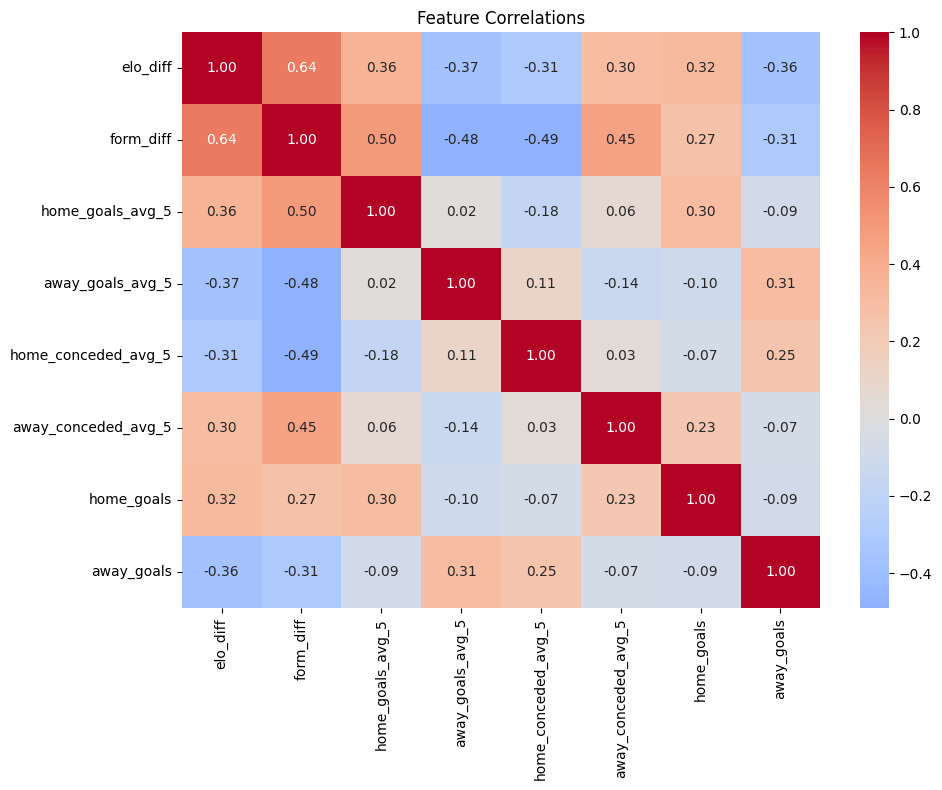


Correlation with home_goals:
home_goals             1.000000
elo_diff               0.315179
home_goals_avg_5       0.297600
form_diff              0.271007
away_conceded_avg_5    0.231037
home_conceded_avg_5   -0.074714
away_goals            -0.085615
away_goals_avg_5      -0.104995
Name: home_goals, dtype: float64


In [5]:
# Prepara dati per correlazione (solo righe complete)
feature_cols = ['elo_diff', 'form_diff', 'home_goals_avg_5', 'away_goals_avg_5',
                'home_conceded_avg_5', 'away_conceded_avg_5']

df_corr = df[feature_cols + ['home_goals', 'away_goals']].dropna()

# Correlation matrix
plt.figure(figsize=(10, 8))
correlation = df_corr.corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

print("\nCorrelation with home_goals:")
print(correlation['home_goals'].sort_values(ascending=False))

## Salvataggio Dataset

In [6]:
# Salva localmente
output_path = '../data/processed/matches_with_features.csv'
df.to_csv(output_path, index=False)

print(f"✅ Dataset with features saved: {output_path}")
print(f"\nDataset shape: {df.shape}")
print(f"Features: {df.shape[1]} columns")

# Sample finale
print("\nSample with all features:")
sample_cols = ['date', 'home_team', 'away_team', 'home_elo_before', 'elo_diff',
               'home_form_5', 'home_goals_avg_5', 'home_goals', 'away_goals', 'result']
print(df[sample_cols].tail())

✅ Dataset with features saved: ../data/processed/matches_with_features.csv

Dataset shape: (2000, 34)
Features: 34 columns

Sample with all features:
           date home_team    away_team  home_elo_before    elo_diff  \
1995 2024-02-16     Inter  Salernitana      1797.656995  432.183374   
1996 2024-02-16    Torino        Lecce      1547.877346  123.609651   
1997 2024-02-16     Inter  Salernitana      1799.191285  435.251954   
1998 2024-02-17    Napoli        Genoa      1595.615920  122.009195   
1999 2024-02-17    Verona     Juventus      1388.082855 -290.252959   

      home_form_5  home_goals_avg_5  home_goals  away_goals result  
1995         15.0               2.2           4           0      H  
1996          7.0               0.8           2           0      H  
1997         15.0               2.8           4           0      H  
1998          7.0               0.8           1           1      D  
1999          3.0               0.6           2           2      D  


## Altre Stats

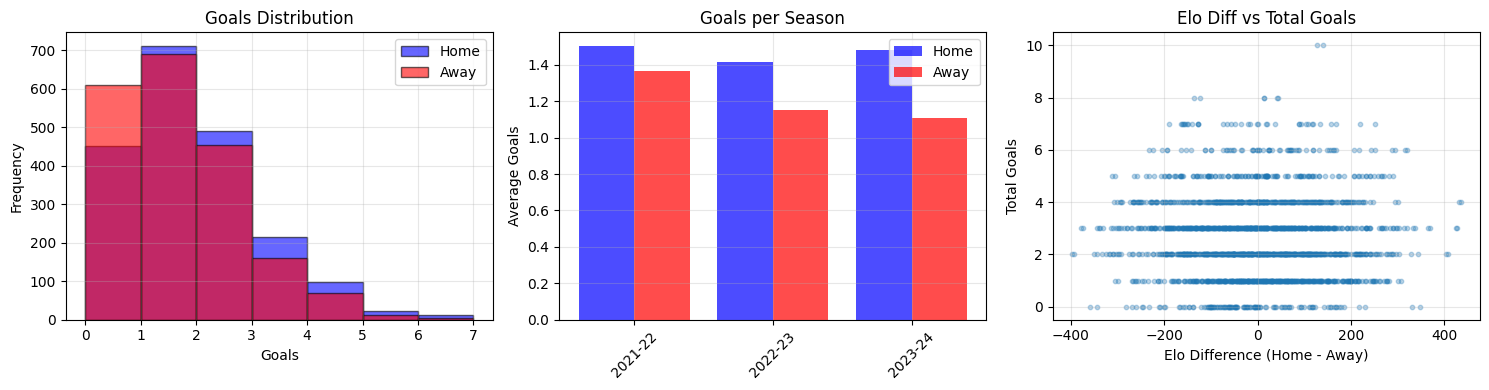

Goals statistics:
Home goals avg: 1.46
Away goals avg: 1.22
Total goals avg: 2.68

Goals std dev: 1.59


In [7]:
# Analisi target variable (home_goals, away_goals)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution
axes[0].hist(df['home_goals'], bins=range(0, 8), alpha=0.6, label='Home', color='blue', edgecolor='black')
axes[0].hist(df['away_goals'], bins=range(0, 8), alpha=0.6, label='Away', color='red', edgecolor='black')
axes[0].set_xlabel('Goals')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Goals Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Goals per season
season_goals = df.groupby('season').agg({
    'home_goals': 'mean',
    'away_goals': 'mean'
}).reset_index()

x = range(len(season_goals))
axes[1].bar([i - 0.2 for i in x], season_goals['home_goals'], width=0.4, label='Home', color='blue', alpha=0.7)
axes[1].bar([i + 0.2 for i in x], season_goals['away_goals'], width=0.4, label='Away', color='red', alpha=0.7)
axes[1].set_xticks(x)
axes[1].set_xticklabels(season_goals['season'], rotation=45)
axes[1].set_ylabel('Average Goals')
axes[1].set_title('Goals per Season')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Elo diff vs Total goals
df['total_goals'] = df['home_goals'] + df['away_goals']
axes[2].scatter(df['elo_diff'], df['total_goals'], alpha=0.3, s=10)
axes[2].set_xlabel('Elo Difference (Home - Away)')
axes[2].set_ylabel('Total Goals')
axes[2].set_title('Elo Diff vs Total Goals')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stats
print("Goals statistics:")
print(f"Home goals avg: {df['home_goals'].mean():.2f}")
print(f"Away goals avg: {df['away_goals'].mean():.2f}")
print(f"Total goals avg: {df['total_goals'].mean():.2f}")
print(f"\nGoals std dev: {df['total_goals'].std():.2f}")